# 4. Ensembles

In [1]:
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, StackingRegressor
from california_data_pipeline import load_train_test
from bayesian_linear_regressor import BayesianLinearRegression
import joblib

## Ensemble intro

### Wisdom of the crowd

If you had a large group of people all take an estimate on how many marbles were in a jar you would get a wide range of answers. An expert on marble guessing may be in the top 10% of closest guesses, but they may still be far off.

However if you had access to all these guesses and simply took the median of them all, you would likely be considered better than the experts.

This phenomenon is known as the wisdom of the crowd; where the average guess often better than average.

### Ensemble methods

Take the above example, but replace marble counters with machine learning models. The predictions of these models can be combined, each taking votes for classification or the results being averaged for regression. This ensemble of models will also outperform its individual components.

A weak learner is a classifier which just better than average. If you created an ensemble of classifiers each with 51% accuracy, given enough weak learners, the ensemble model can perform very well becoming a strong learner.

### Bagging and pasting

One way to create an ensemble is to use the same model on multiple subsets of the data. The individual results of each model are then combined together to get a results which is usually better than the best performing individual model.

When samples are taken out of the dataset and not replaced this is known as pasting, when they are replaced bagging is being performed. Pasting means each model can learn individual patterns as there is no shared data, but a lot of data is needed for this to work well as you are affectively dividing the size of the dataset each model will learn on by the number of models in the ensemble.

One benefit of bagging is that each of the classifiers may not see all of the data point in the training set even though data is being replaced. These unseen data points are known as out-of-bag samples and can be used to validate the models without the need for a seperate validation set which means more data can be used to train the model.

Another method of bagging involves selecting a random number of features to use for that round of training. The idea being that removing some of the features during training rounds reduces an over-reliability on a few features and makes the model learn a more generalised pattern from the data. This is very similar to how dropout can help reduce overfitting in neural networks.

## 4.1 Random Forest

### California housing data

We shall be using the California housing dataset we used with Bayesian regression.

As we have already performed our analysis on the data and selected and transformed our features we shall replicate the same data pipeline from the previous notebook.

To do this I have implemented a transformation pipeline module which gets the California housing data, transforms and creates features as described previously and then returns the train and test data and real values. The function has optional parameters for test size and transformation type, see module for info.

In [2]:
X_train, X_test, y_train, y_test = load_train_test()

In [95]:
X_train.head()

,MedInc,AveOccup,AveBedrmsPerRoom,AveAddRooms,EstHouses,DistToTown
15536,-1.114001,-0.813383,1.616400,-1.473897,0.796013,-0.592870
12143,-0.914646,1.260378,-0.905558,1.550903,-1.113609,0.497750
9669,-0.258580,2.651988,1.785041,-2.053961,-1.649685,-1.150917
3005,-0.534559,-0.116728,0.497786,-0.324815,0.074911,2.346136
17756,-0.165095,-0.325182,-0.864095,0.789426,0.039902,1.489587


In [5]:
y_train.head()

,MedHouseVal
15536,0.253606
12143,-1.014571
9669,-0.245760
3005,-1.446104
17756,-0.792733


### Decisions trees

A decision tree performs classification or regression based on a flow-chart like graph, where an input to the tree starts at the root and makes its way through the tree based on conditions for each feature of the data point at each node of the tree. At the bottom of the tree is the output prediction for the input features. This is best demontsrated with a diagram 

>>> INSERT DECISION TREE

Decision tree models are trained through supervised learning. The tree finds the optimal way to split the training data at each level, an example might be splitting the tree for houses that are less than 10km from LA and those which are not. The combination of these feature splits can result in very complex models being learned.

We shall train a simple decision tree regressor with the preprocessed California housing data we just loaded in.

In [58]:
tree_reg = DecisionTreeRegressor()
tree_reg.fit(X_train, y_train)

DecisionTreeRegressor()

We can then make predictions of the test set values and get scores for R2, MSE, RMSE.

In [59]:
# output R2, MSE and RMSE regressor
def reg_metrics(reg, reg_name, X, y):
    reg_preds = reg.predict(X)
    reg_r2 = r2_score(y, reg_preds)
    reg_mse = mean_squared_error(y, reg_preds)
    reg_rmse = mean_squared_error(y, reg_preds, squared=False)
    print(f"{reg_name} regression R2:   {reg_r2:.4f}")
    print(f"{reg_name} regression MSE:  {reg_mse:.4f}")
    print(f"{reg_name} regression RMSE: {reg_rmse:.4f}")

In [60]:
reg_metrics(tree_reg, "decision tree", X_test, y_test)

decision tree regression R2:   0.4151
decision tree regression MSE:  0.5978
decision tree regression RMSE: 0.7732


As we have used the same data and the same preprocessing (albeit with different random test train split), we can make reasonably accurate comparisons between each of the models we have trained on the data.

Looking at the metrics above we can see our decision tree has done quite well, although not as good of a fit as our Bayesian linear regression model.

Lets see how we can apply ensemble methods to produce even better results.

### Random forest

A random forest is an ensemble of decision trees. Using bagging, a number of decision trees are trained together on sub-sets of the training data. The results from each tree are the agregated, producing a result far better than each of its parts.

Random forests also implement the random feature selection mentioned previously. Instead of splitting the tree with the best feature, it takes a subset of the features and finds the best split in that. This allows for more features to be utilised by the model and deeper patterns to be learned over non-randomising the feature sets.

As above we shall train on the test data and analyse the results, but this time with an ensemble of 10 decision trees.

In [127]:
forest_reg = RandomForestRegressor(n_estimators=10)
forest_reg.fit(X_train, np.ravel(y_train))

RandomForestRegressor(n_estimators=10)

In [128]:
reg_metrics(forest_reg, "random forest", X_test, y_test)

random forest regression R2:   0.6738
random forest regression MSE:  0.3310
random forest regression RMSE: 0.5753


With just 10 trees, we have managed to increase R2 and decrease both MSE and RMSE significantly.

Lets try increasing the number of estimators to further benefit from the windom of the crowds.

In [138]:
forest_reg = RandomForestRegressor(n_estimators=100)
forest_reg.fit(X_train, np.ravel(y_train))
reg_metrics(forest_reg, "random forest", X_test, y_test)

random forest regression R2:   0.6956
random forest regression MSE:  0.3089
random forest regression RMSE: 0.5558


Lets check how well it fit to the data it was tested on and see if we are overfitting.

In [139]:
reg_metrics(forest_reg, "random forest", X_train, y_train)

random forest regression R2:   0.9576
random forest regression MSE:  0.0426
random forest regression RMSE: 0.2064


It seems like the model has overfit and not generalised to the test set as well as it could have. Increasing the number of estimators and constraining the tree depth should force the ensemble to generalise more as it learns more important patterns.

In [140]:
forest_reg = RandomForestRegressor(n_estimators=5000, max_depth=10, n_jobs=-1)
forest_reg.fit(X_train, np.ravel(y_train))
reg_metrics(forest_reg, "random forest test", X_test, y_test)

random forest test regression R2:   0.6954
random forest test regression MSE:  0.3090
random forest test regression RMSE: 0.5559


In [141]:
reg_metrics(forest_reg, "random forest train", X_train, y_train)

random forest train regression R2:   0.8158
random forest train regression MSE:  0.1851
random forest train regression RMSE: 0.4302


As expected we have constrained each model and forcing each to learn stronger patterns helps the ensemble generalise more. Although we have overfit the training set it does seem there is more we can do.

We shall run a random hyper parameter search on some different parameters to get a better idea of optimal tree constraints.

Random forest default parameters:
- n_estimators=100,
- max_depth=Non
- min_samples_split=2
- min_samples_leaf=1
- min_weight_fraction_leaf=0.0
- max_features='auto'
- max_leaf_nodes=None
- min_impurity_decrease=0.0
- min_impurity_split=None
- bootstrap=True
- ccp_alpha=0.0
- max_samples=None

In [96]:
n_estimators = np.arange(100, 1000)
max_features = ['auto', 'sqrt', 'log2']
max_depth = np.arange(3, 20)
min_samples_split = np.arange(1, 100)
min_samples_leaf = np.arange(1, 100)
bootstrap = [True, False]

forest_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

forest_reg = RandomForestRegressor()

forest_randomcv = RandomizedSearchCV(forest_reg, forest_grid, n_iter=100, cv=2)

In [97]:
forest_randomcv.fit(X_train, np.ravel(y_train))

RandomizedSearchCV(cv=2, estimator=RandomForestRegressor(), n_iter=100,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]),
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 3...
       906, 907, 908, 909, 910, 911, 912, 913, 914, 915, 916, 917, 918,
       919, 920, 921, 922, 923, 924, 925, 926, 927, 928, 929, 930, 931,
       932, 933, 934, 935, 936, 937, 938, 939, 940, 941, 942, 943, 944,
       945, 946, 947, 948, 949, 950, 951, 952, 953, 954, 955, 956, 957,
       958, 959, 960, 961, 962, 963, 964, 965, 966, 967, 968, 969

As this takes a while we shall pickle and unpickle the search object.

In [101]:
joblib.dump(forest_randomcv, 'forest_randomcv2.pkl')

['forest_randomcv2.pkl']

In [111]:
forest_randomcv = joblib.load('forest_randomcv2.pkl')

We can now look at the best parameters from the search.

In [113]:
forest_randomcv.best_params_

{'n_estimators': 704,
 'min_samples_split': 21,
 'min_samples_leaf': 14,
 'max_features': 'sqrt',
 'max_depth': 12,
 'bootstrap': True}

Some intial insights are that increasing the number of trees in the ensemble improves performance, this makes sense as we further benefit from the effect of wisom of the crowds. Boostrapping be set to true also makes sense as the dataset isnt huge so more training data variety for each tree should improve overall performance. It seems we were also right in constraining the max depth of the tree, similar results can be seen from limiting the maximum number of features - I shall go more in depth with this later on. As for the increase in minimum samples this also makes sense as stronger decision boundaries have to be made, i.e. a boundary cannot be put between 2 samples. This means the model should generalise more.


Now lets load this into a new random forest and evaluate it on the test set.

In [144]:
best_forest = forest_randomcv.best_estimator_

In [293]:
reg_metrics(best_forest, "best random forest regressor", X_test, y_test)

best random forest regressor regression R2:   0.7419
best random forest regressor regression MSE:  0.2619
best random forest regressor regression RMSE: 0.5118


We have managed to get a 10% increase the R2 score, whilst also reducing MSE and RMSE.

Let's also check the results on the training data to see how well it generalised.

In [147]:
reg_metrics(best_forest, "best random forest test", X_train, y_train)

best random forest test regression R2:   0.7512
best random forest test regression MSE:  0.2499
best random forest test regression RMSE: 0.4999


An almost perfect generalisation! Although the training R2 score has decreased, this is actually a good sign as it indicates a reduction in overfitting when combined with the increased performance on the testing set. This result is also in part to the model being tested using cross-validation.

### Trees in a forest

To visualise how the number of trees in the ensemble affects the training time and accuracy score trade-off I run a grid search with increasing numbers of estimators. This will allow me to check training times as well as training and testing scores from the cross-validation.

- Plot the trade off between training time and performance
- What is the optimal (wrt. training time and accuracy) number of trees

In [190]:
n_forest_grid = {'n_estimators': [int(x) for x in np.linspace(1, 150, 50)]}

n_forest_gridsearch = GridSearchCV(best_forest,
                                   param_grid=n_forest_grid,
                                   cv=2, return_train_score=True)

n_forest_gridsearch.fit(X_train, np.ravel(y_train))

GridSearchCV(cv=2,
             estimator=RandomForestRegressor(max_depth=12, max_features='sqrt',
                                             min_samples_leaf=14,
                                             min_samples_split=21,
                                             n_estimators=704),
             param_grid={'n_estimators': [1, 4, 7, 10, 13, 16, 19, 22, 25, 28,
                                          31, 34, 37, 40, 43, 46, 49, 52, 55,
                                          58, 61, 64, 67, 70, 73, 77, 80, 83,
                                          86, 89, ...]},
             return_train_score=True)

Now we have our results we can plot `n_estimators` against training time and score.

Text(0.5, 1.0, 'Time to train random forest with increasing number of trees')

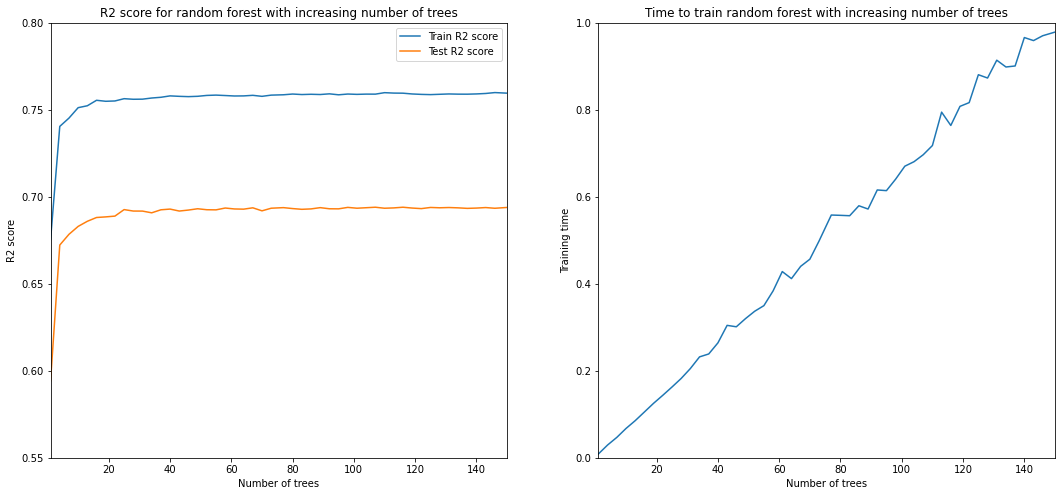

In [292]:
df = pd.DataFrame()
df['Number of trees'] = n_forest_gridsearch.cv_results_['param_n_estimators']
df['Training time'] = n_forest_gridsearch.cv_results_['mean_fit_time']
df['Train R2 score'] = n_forest_gridsearch.cv_results_['mean_train_score']
df['Test R2 score'] = n_forest_gridsearch.cv_results_['mean_test_score']

fig1_df = df[['Number of trees', 'Train R2 score', 'Test R2 score']]
fig1_df = pd.melt(fig1_df, ['Number of trees'], var_name="",
                  value_name="R2 score")

fig, ax = plt.subplots(figsize=(18, 8))

plt.subplot(121)
fig1 = sns.lineplot(data=fig1_df, x='Number of trees', y='R2 score', hue='')
fig1.set(xlim=[1, 150], ylim=[0.55, 0.8])
fig1.set_title("R2 score for random forest with increasing number of trees")

plt.subplot(122)
fig2 = sns.lineplot(data=df, x="Number of trees", y="Training time")
fig2.set(xlim=[1, 150], ylim=[0, 1])
fig2.set_title("Time to train random forest with increasing number of trees")

From the above graphs we can see that adding more trees to the model only increases its performance up to a point where it begins to level of sharply. This is likely due to a limit in the amount of data or the small number of features meaning it can be represented by a reletively small number of trees and still produce a good score. From the graph on the right we can see that training time scales linearly with then number of additional trees added to the forest. From these results it seems around 15-20 decision trees in our random forest ensemble would produce optimal results with minimal complexity.

### Limiting branches and features

As we saw with our randomised search recuding tree depth gave good results for our model. Forcing each tree to be unable to learn highly complex patterns in the data means it must find stronger decision boundaries in order to perform well. These stronger decision boundaries result in a more robust model which better generalises.

Reducing the max features from the number of features to the sqaure root of that number has also proved useful. I figure this makes the regressor learn from a wider variety of features than always relying on a few strong ones such as median income.

Similarly to above we can run grid searches for `max_depth` and `max_features` and aboserve their affects on the accuracy of the model.

In [301]:
depth_grid = {'max_depth': [int(x) for x in np.linspace(1, 30, 20)]}
depth_gridsearch = GridSearchCV(best_forest,
                                param_grid=depth_grid,
                                cv=2, return_train_score=True)
depth_gridsearch.fit(X_train, np.ravel(y_train))

GridSearchCV(cv=2,
             estimator=RandomForestRegressor(max_depth=12, max_features='sqrt',
                                             min_samples_leaf=14,
                                             min_samples_split=21,
                                             n_estimators=704),
             param_grid={'max_depth': [1, 2, 4, 5, 7, 8, 10, 11, 13, 14, 16, 17,
                                       19, 20, 22, 23, 25, 26, 28, 30]},
             return_train_score=True)

In [302]:
n_features = X_train.shape[1]
features_grid = {'max_features': [int(x) for x in range(1, n_features+1)]}
features_gridsearch = GridSearchCV(best_forest,
                                   param_grid=features_grid,
                                   cv=2, return_train_score=True)
features_gridsearch.fit(X_train, np.ravel(y_train))

GridSearchCV(cv=2,
             estimator=RandomForestRegressor(max_depth=12, max_features='sqrt',
                                             min_samples_leaf=14,
                                             min_samples_split=21,
                                             n_estimators=704),
             param_grid={'max_features': [1, 2, 3, 4, 5, 6]},
             return_train_score=True)

Now we can plot these agaist their test and training scores during cross-validation.

Text(0.5, 1.0, 'Random Forest with Increasing Number of Features Condisered')

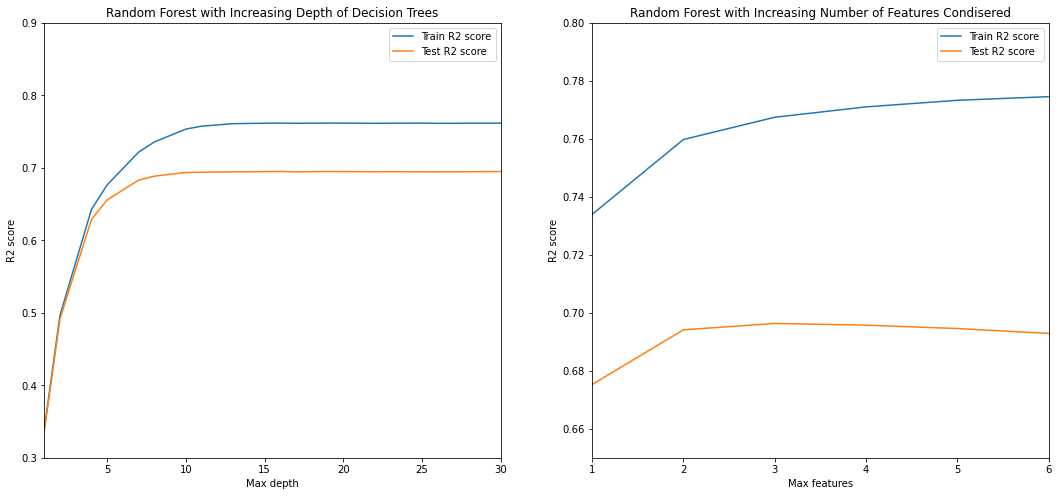

In [308]:
df1 = pd.DataFrame()
df1['Max depth'] = depth_gridsearch.cv_results_['param_max_depth']
df1['Train R2 score'] = depth_gridsearch.cv_results_['mean_train_score']
df1['Test R2 score'] = depth_gridsearch.cv_results_['mean_test_score']
fig1_df = df1[['Max depth', 'Train R2 score', 'Test R2 score']]
fig1_df = pd.melt(fig1_df, ['Max depth'], var_name="",
                  value_name="R2 score")

df2 = pd.DataFrame()
df2['Max features'] = features_gridsearch.cv_results_['param_max_features']
df2['Train R2 score'] = features_gridsearch.cv_results_['mean_train_score']
df2['Test R2 score'] = features_gridsearch.cv_results_['mean_test_score']
fig2_df = df2[['Max features', 'Train R2 score', 'Test R2 score']]
fig2_df = pd.melt(fig2_df, ['Max features'], var_name="",
                  value_name="R2 score")


fig, ax = plt.subplots(figsize=(18, 8))

plt.subplot(121)
fig1 = sns.lineplot(data=fig1_df, x='Max depth', y='R2 score', hue='')
fig1.set(xlim=[1, 30], ylim=[0.3, 0.9])
fig1.set_title("Random Forest with Increasing Depth of Decision Trees")

plt.subplot(122)
fig2 = sns.lineplot(data=fig2_df, x="Max features", y="R2 score", hue='')
fig2.set(xlim=[1, 6], ylim=[0.65, 0.8])
fig2.set_title("Random Forest with Increasing Number of Features Condisered")

It seems that increasing the max depth of decision trees past 10 has no affect on the model's performance. This is likely due to some other part of the model causing trees not to be grown past this point. Increasing max-depth past this point therefore has no benefit.

When considering features at each not it seems using more than 3 tends to overfit. We can see this as the testing accuracy starts to drop from 4 onwards, while training scores continue to increase. Either considering 2 or 3 features seems to be best, as they are so close 2 features may be the better choice if we wish to generalise better. 

Out current random forest has a max depth of 12 and max features of sqrt(6) = 2, which is very close to the optimal values from the above graphs so we shall keep out current trained model as it is already producing good results.

### Extremely randomised trees

Also called extra trees, extremely randomised trees are an additional extension to the random forest. Where random forests select the best split of a random subset of features, extra trees further increase randomness by selecting a random threshold for each feature.

This can produce models which learn more generalised patterns, but their main benifit is they have a much lower computational complexity than random forests.

Lets create an extra tree regressor and see how it performs on the training data.

- Additional check of extra trees vs random forest
    - use opt forest params for both
    - or quick grid search for extra trees

In [313]:
extra_reg = ExtraTreesRegressor()
extra_reg.fit(X_train, np.ravel(y_train))
reg_metrics(extra_reg, "extra trees test", X_test, y_test)

extra trees test regression R2:   0.7014
extra trees test regression MSE:  0.3030
extra trees test regression RMSE: 0.5505


With the default parameters we get an R2 score on the test set very close to our optimised random forest. 

Lets see how it performed on the training set.

In [314]:
reg_metrics(extra_reg, "extra trees test", X_train, y_train)

extra trees test regression R2:   1.0000
extra trees test regression MSE:  0.0000
extra trees test regression RMSE: 0.0000


Thats not good, it has completely fit to the training set. We will need to constrain the model to get it to generalise.

We shall use the parameters from out optimal model and compare them with the random forest to get an idea of which performs better for our task.

In [329]:
extra_reg = ExtraTreesRegressor(n_estimators=20,
                                min_samples_split=20,
                                min_samples_leaf=10,
                                max_features='sqrt',
                                max_depth=10,
                                bootstrap=True)
extra_reg.fit(X_train, np.ravel(y_train))
reg_metrics(extra_reg, "extra trees train", X_train, y_train)
reg_metrics(extra_reg, "extra trees test ", X_test, y_test)

extra trees train regression R2:   0.5848
extra trees train regression MSE:  0.4170
extra trees train regression RMSE: 0.6458
extra trees test  regression R2:   0.5699
extra trees test  regression MSE:  0.4364
extra trees test  regression RMSE: 0.6606


It seems the optimal parameters are not transferable between random forests and extra trees so we will need to run another random search.

In [ ]:
n_estimators = np.arange(100, 1000)
max_features = ['auto', 'sqrt', 'log2']
max_depth = np.arange(3, 20)
min_samples_split = np.arange(1, 100)
min_samples_leaf = np.arange(1, 100)
bootstrap = [True, False]

extra_grid = {'n_estimators': n_estimators,
              'max_features': max_features,
              'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf,
              'bootstrap': bootstrap}

extra_reg = ExtraTreesRegressor()

extra_randomcv = RandomizedSearchCV(extra_reg, extra_grid, n_iter=100, cv=2)

In [ ]:
extra_randomcv.fit(X_train, np.ravel(y_train))

In [324]:
joblib.dump(extra_randomcv, 'extra_randomcv.pkl')

['extra_randomcv.pkl']

In [325]:
extra_randomcv.best_params_

{'n_estimators': 618,
 'min_samples_split': 58,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 14,
 'bootstrap': False}

In [328]:
best_extra = extra_randomcv.best_estimator_
reg_metrics(best_extra, "extra trees train", X_train, y_train)
reg_metrics(best_extra, "extra trees test ", X_test, y_test)

extra trees train regression R2:   0.7409
extra trees train regression MSE:  0.2602
extra trees train regression RMSE: 0.5101
extra trees test  regression R2:   0.7296
extra trees test  regression MSE:  0.2744
extra trees test  regression RMSE: 0.5238


Without further parameter exploration it seems that we have reached a performance similar to the random forest. As performance is relatively similar I shall continue with the `RandomForestRegressor` as not not need to optimise hyperparameters further.

### Interpreting a forest

- Easier to look at a decision tree but still too large to comprehend
    - nothing to learn from looking at the tree that the model hasnt learnt already
- Decision trees are weak learners
    - small change in input can lead to different trees
    - look at .feature_importance_ for a few subsets
- Random forests are much stronger learners
    - look at .feature_importance_ for same subsets
    - shouldnt change as much as decision tree

## 4.2 Stacking

### Stacking

Stacking takes the idea of ensemble learning further by replacing the simple model agrigation methods such as voting and averaging with another model which is trained by each model's votes. Each model in the prediction ensemble gives its results to a blending model which outputs a final result.

>>> Stacking diagram

### Stacking random forests

- Stack random forests together
- Compare to optimal random forest
- Create ensemble of random forests and take mean of results
- Compare to stacked and normal random forest

In [331]:
forest_reg = best_forest

estimators = [('forest_reg0', forest_reg),
              ('forest_reg1', forest_reg),
              ('forest_reg2', forest_reg)]

blender = DecisionTreeRegressor(max_depth=10)

stacking_forest = StackingRegressor(estimators=estimators,
                                    final_estimator=blender)

We can now fit the stacking ensemble to the training data a normal regression model.

In [333]:
stacking_forest.fit(X_train, np.ravel(y_train))

StackingRegressor(estimators=[('forest_reg0',
                               RandomForestRegressor(max_depth=12,
                                                     max_features='sqrt',
                                                     min_samples_leaf=14,
                                                     min_samples_split=21,
                                                     n_estimators=704)),
                              ('forest_reg1',
                               RandomForestRegressor(max_depth=12,
                                                     max_features='sqrt',
                                                     min_samples_leaf=14,
                                                     min_samples_split=21,
                                                     n_estimators=704)),
                              ('forest_reg2',
                               RandomForestRegressor(max_depth=12,
                                                     max_features='sq

We can now analyse the results on the test set.

In [334]:
reg_metrics(stacking_forest, "stacking random forest test", X_test, y_test)

stacking random forest test regression R2:   0.6575
stacking random forest test regression MSE:  0.3476
stacking random forest test regression RMSE: 0.5895


It seems stacking together our optimised random forest has not produced results better than what we had originally.

It may be better to stack together smaller random forests with less estimators.

In [339]:
forest_reg = RandomForestRegressor(n_estimators=10, max_depth=10)
estimators = [('forest_reg0', forest_reg),
              ('forest_reg1', forest_reg),
              ('forest_reg2', forest_reg),
              ('forest_reg3', forest_reg),
              ('forest_reg4', forest_reg),
              ('forest_reg5', forest_reg),
              ('forest_reg6', forest_reg),
              ('forest_reg7', forest_reg),
              ('forest_reg8', forest_reg),
              ('forest_reg9', forest_reg)]
blender = DecisionTreeRegressor(max_depth=10)
stacking_forest = StackingRegressor(estimators=estimators,
                                    final_estimator=blender)
stacking_forest.fit(X_train, np.ravel(y_train))
reg_metrics(stacking_forest, "stacking random forest test", X_test, y_test)

stacking random forest test regression R2:   0.6450
stacking random forest test regression MSE:  0.3602
stacking random forest test regression RMSE: 0.6002


### Bayesian linear regression

In the previous task I created a Scikit-learn wrapper for the PyMC3 baysian linear regression model I created for the California housing data. I shall use this in my stacking ensemble.

In [45]:
import bayesian_linear_regressor as br
import importlib
importlib.reload(br)

X_train, X_test, y_train, y_test = load_train_test()
target = y_train.columns[0]
features = X_train.columns
print(target, features)

bayesian_reg = br.BayesianLinearRegression(target=target,
                                           features=features,
                                           is_frame=False)

MedHouseVal Index(['MedInc', 'AveOccup', 'AveBedrmsPerRoom', 'AveAddRooms', 'EstHouses',
       'DistToTown'],
      dtype='object')


Note: as the bayesian linear regression model produces a probability distribution rather than a single estimate, the predict method of the class predicts using the mean of the samples from the distribution. This means I can return a R2 score allowing iheritance of Scikit-learn `base.RegressorMixin` and stacking with `StackingRegressor`. 

The formula for the model must also be specified in the constructor as `StackingRegressor` converts Pandas data frames to Numpy arrays and we lose the column names used to specify the model.

### Stacking random forest and bayesian linear regression

The stacking architecture will be a random forest and bayesian linear regressor in one layer. For the blender model I shall use a simple decision tree.

>>> Stacking architecture diagram

To implement this stacking ensemble I shall use scikit-learn's `StackingRegressor`.

In [46]:
# bayesian_regressor = br.BayesianLinearRegression(formula=formula)
forest_reg = RandomForestRegressor(n_estimators=10, max_depth=10)

estimators = [('forest_reg', forest_reg),
              ('bayesian_reg', bayesian_reg)]

blender = DecisionTreeRegressor(max_depth=10)

bayesian_forest_stack = StackingRegressor(estimators=estimators,
                                          final_estimator=blender)

Now we can fit this to the California housing data.

In [ ]:
bayesian_forest_stack.fit(X_train, np.ravel(y_train))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [sd, DistToTown, EstHouses, AveAddRooms, AveBedrmsPerRoom, AveOccup, MedInc, Intercept]
Sampling 8 chains, 0 divergences: 100%|██████████| 56000/56000 [01:00<00:00, 921.36draws/s] 
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [sd, DistToTown, EstHouses, AveAddRooms, AveBedrmsPerRoom, AveOccup, MedInc, Intercept]
Sampling 8 chains, 0 divergences: 100%|██████████| 56000/56000 [00:40<00:00, 1393.34draws/s]


In [9]:
bayesian_forest_stack.score(X_test, y_test)

0.633475685250305

### Multi-layer stacking

The idea of stacking can be extended further, allowing multiple layers of stacked models on-top of eachother. The layers of models can also be different types of models themselves. 

I shall use this method to stack together a random forest regressor and a bayesian linear regressor. The idea being that the two varied approaches to regression come together for a stronger solution.

In [384]:
bayesian_regressor = br.BayesianLinearRegression(formula=formula)

forest_estimators = [('forest_reg0', RandomForestRegressor(n_estimators=10,
                                                           max_depth=10)),
                     ('forest_reg1', RandomForestRegressor(n_estimators=10,
                                                           max_depth=10)),
                     ('forest_reg2', RandomForestRegressor(n_estimators=10,
                                                           max_depth=10))]

bayesian_estimators = [('bayesian_reg0', bayesian_regressor),
                       ('bayesian_reg1', bayesian_regressor),
                       ('bayesian_reg2', bayesian_regressor)]

blender = DecisionTreeRegressor()

internal_stack = StackingRegressor(estimators=bayesian_estimators,
                                   final_estimator=blender)

bayesian_forest_stack = StackingRegressor(estimators=forest_estimators,
                                          final_estimator=internal_stack)

MedHouseVal ~ MedInc + AveOccup + AveBedrmsPerRoom + AveAddRooms + EstHouses + DistToTown


Now we can fit this to the data.

In [ ]:
bayesian_forest_stack.fit(X_train, y_train)

/home/kai/anaconda3/envs/ml/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


None
None
None
None
Sampling with formula:
MedHouseVal ~ MedInc + AveOccup + AveBedrmsPerRoom + AveAddRooms + EstHouses + DistToTown



/home/kai/anaconda3/envs/ml/lib/python3.7/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


### Stacking tasks

Bayesian linear regression and decision trees are two very different approaches to regression.  Ensemble methods can exploit such diversity between different methods to improve performance.  So now you will try combining the random forest  and  Bayesian  linear  regression  using stacking.

Scikit-learn  includes the  StackingRegressor  class  to  help  you  with  this.   In  the  report,  explain the stacking approach and describe your results,  making sure to cover the following points:

1. When does stacking improve performance over the individual models (e.g. try stacking with a random forest with 'maxdepth=10' and 'nestimators=10')?
2. What happens if we just take the mean prediction from our base models instead?
3. Use a DecisionTreeRegressor as the final estimator and visualise the tree to understand what stacking is doing.

## Ensemble Conclusion

### Comparison of random forest and stacking

- Comparison of random forest and stacking methods
  - Accuracy
  - Computational complexity
  - Data needed
  - Generalisation / ease of use